# Create ground truth estimations of PSI values

Code adapted from `simulate-batcheffect.r` 

In [1]:
library(readr)
library(data.table)
library(dplyr)
library(ggplot2)
library(VGAM)
library(drc)
library(tidyr)
source("trex_helper.r")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: stats4

Loading required package: splines

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



'drc' has been loaded.


Please cite R and 'drc' if used for a publication,

for references type 'citation()' and 'citation('drc')'.



Attaching package: ‘drc’


The following objects are masked from ‘package:VGAM’:

    gompertz, logistic


The following objects are masked from ‘package:stats’:

    gaussian, getInitial



Attaching package: ‘tidyr’


The following object is masked from ‘package:VGAM’:

    fill




## TRex Functions

In [2]:
trex_counts<-function(counts,trex.map,...){
  
    
 trex_sum <- as.data.frame(counts) %>%
                tibble::rownames_to_column("ensembl_transcript_id") %>%
                inner_join(.,trex.map,by = "ensembl_transcript_id") %>%
                dplyr::select(-ensembl_transcript_id) %>%
                group_by(event_id) %>%
                summarize_all(sum)
    
  return(trex_sum)
}

trex_means<-function(lengths,trex.map,...){
  
  trex_mean<-aggregate(lengths[trex.map$ensembl_transcript_id,],
                       list(event_id = trex.map$event_id),
                       function(x){mean(x,na.rm = F)}) %>% 
    tibble::column_to_rownames("event_id")
  return(trex_mean)
}

correct_sim_counts<-function(trex){

    mats<-list()
    for(tc in c("A","C")){
        cols <- grepl(paste0(tc,"_"),colnames(trex$counts))

        # Retrieve counts and length matrices
        countsMat <- trex$counts[,cols]
        lengthMat <- trex$length[,cols] 
        tpmMat <- trex$abundance[,cols]

        # Re-esimate abundances for the trex count type
        tpmSum <- colSums(tpmMat)
        abundanceMat <- t(t(tpmMat)/tpmSum*1e6)

        # Estimate counts from abundances per trex count type
        eCountsMat <- abundanceMat * rowMeans(lengthMat) # Scale to average length over all samples
        scaleFactor <- colSums(countsMat,na.rm=T)/colSums(eCountsMat,na.rm=T)
        eCountsMat <- t(t(eCountsMat) * scaleFactor)

        mats[[tc]] <- list("counts"=eCountsMat,"abundance"=abundanceMat,"length"=lengthMat)
    }
    trex$counts<-cbind(mats[["A"]][["counts"]],mats[["C"]][["counts"]])
    trex$abundance<-cbind(mats[["A"]][["abundance"]],mats[["C"]][["abundance"]])
    trex$length<-cbind(mats[["A"]][["length"]],mats[["C"]][["length"]])
    trex$countsFromAbundance<-"lengthScaledTPM"

    return(trex)
}

create_trex_object<-function(transcript.txi,alt_isos,const_isos){

    message("Converting to event counts...")
    
    tpm<-transcript.txi$abundance
    countsMat<-transcript.txi$counts
    lengthMat<-transcript.txi$length
    
    tpm_alt<-trex_counts(tpm,alt_isos) %>% 
         dplyr::select(event_id,K562_control_rep1,K562_SRSF9.KD_rep1) %>%
         rename("A_K562_control"="K562_control_rep1",
               "A_K562_SRSF9.KD"="K562_SRSF9.KD_rep1")

    tpm_const<-trex_counts(tpm,const_isos) %>% 
               dplyr::select(event_id,K562_control_rep1,K562_SRSF9.KD_rep1) %>%
               rename("C_K562_control"="K562_control_rep1",
                   "C_K562_SRSF9.KD"="K562_SRSF9.KD_rep1")

    cts_alt<-trex_counts(countsMat,alt_isos) %>% 
             rename("A_K562_control"="K562_control_rep1",
                   "A_K562_SRSF9.KD"="K562_SRSF9.KD_rep1")

    cts_const<-trex_counts(countsMat,const_isos) %>% 
               rename("C_K562_control"="K562_control_rep1",
                      "C_K562_SRSF9.KD"="K562_SRSF9.KD_rep1")

    len_alt <- right_join(alt_isos,lengthMat %>% tibble::rownames_to_column("ensembl_transcript_id")) %>%
                group_by(event_id) %>%
                summarize(A_K562_control=mean(K562_control_rep1),
                          A_K562_SRSF9.KD=mean(K562_SRSF9.KD_rep1))
    len_const <- right_join(const_isos,lengthMat %>% tibble::rownames_to_column("ensembl_transcript_id")) %>%
                 group_by(event_id) %>%
                 summarize(C_K562_control=mean(K562_control_rep1),
                          C_K562_SRSF9.KD=mean(K562_SRSF9.KD_rep1))

    trex<-list()
    trex$abundance<-inner_join(tpm_alt,tpm_const,by="event_id") %>% na.omit() %>% tibble::column_to_rownames("event_id")
    trex$counts<-inner_join(cts_alt,cts_const,by="event_id") %>% na.omit()%>% tibble::column_to_rownames("event_id")
    trex$length<-inner_join(len_alt,len_const,by="event_id") %>% na.omit()%>% tibble::column_to_rownames("event_id")
    
    message("Correcting event counts...")
    trex.c<-correct_sim_counts(trex)
    
    return(trex.c)
    message("Done!")
}

## Load data

In [3]:
dir_input <- "/home/lmoral7/lmprojects/altsplicing-methods/simulations/data/observed_counts"
sample_file <- "K562_control_rep1/rsem.isoforms.results"
sample_file_2 <- "K562_SRSF9.KD_rep1/rsem.isoforms.results"
asmapfile <- "/home/lmoral7/lmprojects/references/gencode_GRCh38.p13/SUPPA2_splicemap/modID.GRCh38.p13.gencode.v37.primary_assembly.annotation_ASALL_strict.ioe"

In [4]:
## Splicing GTF map

asmap<-fread(asmapfile,data.table = F,stringsAsFactors = F) %>% 
        as.data.frame() %>% 
        filter(event_type=="SE") %>% distinct() 
rownames(asmap)<-asmap$event_id

In [5]:
## Ground truth counts 

iso_res_rsem<-read.table(file.path(dir_input,sample_file),header=TRUE)
iso_res_kd_rsem<-read.table(file.path(dir_input,sample_file_2),header=TRUE)
obs_TPM <- fread(file.path(dir_input,"ground_truth_TPM.tsv"),data.table=FALSE)
simulation_design <- fread(file.path(dir_input,"metadata.tsv"))
lengthMat <-  inner_join(iso_res_rsem[,c("transcript_id","effective_length")]  %>% rename("K562_control_rep1"="effective_length") ,
                         iso_res_kd_rsem[,c("transcript_id","effective_length")] %>% rename("K562_SRSF9.KD_rep1"="effective_length")) %>%
              tibble::column_to_rownames("transcript_id")
countsMat <- inner_join(iso_res_rsem[,c("transcript_id","expected_count")]  %>% rename("K562_control_rep1"="expected_count") ,
                         iso_res_kd_rsem[,c("transcript_id","expected_count")] %>% rename("K562_SRSF9.KD_rep1"="expected_count")) %>%
              tibble::column_to_rownames("transcript_id")

n_transcripts <- nrow(obs_TPM)
pseudocount <- 1e-3
set.seed(7)

Joining, by = "transcript_id"
Joining, by = "transcript_id"


In [6]:
## Assign events to isoforms 

alt_isos<-asmap %>%
        group_by(event_id)%>%
        mutate(ensembl_transcript_id=strsplit(alternative_transcripts,",")) %>%
        tidyr::unnest(ensembl_transcript_id) %>%
        dplyr::select(event_id,ensembl_transcript_id) %>% 
        ungroup() %>%
        left_join(.,iso_res_rsem %>% distinct(transcript_id) %>% rename("ensembl_transcript_id"="transcript_id"))

const_isos<-asmap %>%
            group_by(event_id)%>%
            mutate(ensembl_transcript_id=strsplit(constitutive_transcripts,",")) %>%
            tidyr::unnest(ensembl_transcript_id) %>%
            dplyr::select(event_id,ensembl_transcript_id) %>% 
            ungroup() %>%
            left_join(.,iso_res_rsem %>% distinct(transcript_id) %>% rename("ensembl_transcript_id"="transcript_id"))

Joining, by = "ensembl_transcript_id"
Joining, by = "ensembl_transcript_id"


In [7]:
nonZero_TPMs <- rowSums( obs_TPM > 0 ) 
nonZero_indices <- which( nonZero_TPMs >= 4 ) 

log_obs_TPM_c1 <- ( log(obs_TPM[nonZero_indices,1]+pseudocount) + log(obs_TPM[nonZero_indices,2]+pseudocount) ) / 2
log_obs_TPM_c2 <- ( log(obs_TPM[nonZero_indices,3]+pseudocount) + log(obs_TPM[nonZero_indices,4]+pseudocount) ) / 2
obs_logFC <- log_obs_TPM_c2 - log_obs_TPM_c1

cv.data <- data.frame(mean_exp = (log_obs_TPM_c1+log_obs_TPM_c2)/2,logFC = obs_logFC )
cv.data <- cv.data[ order(cv.data$mean_exp), ]
cv.data$sd <- sapply( 1:nrow(cv.data), function(x) sd(cv.data$logFC[max(x-500,1):min(x+500,nrow(cv.data))]) )
                     
print("Fitting mean variance model")
logFC_vs_mean_fit <- drm(sd ~ mean_exp, data = cv.data, fct = L.4(), type = "continuous")

obs_TPM_NA <- obs_TPM
obs_TPM_NA[ obs_TPM_NA == 0 ] <- NA
obs_TPM_NA_mean <- apply(obs_TPM_NA,1,mean,na.rm=T)

c1_probs <- rank(obs_TPM_NA_mean,na.last="keep",ties.method="random")
c1_probs <- c1_probs / max(c1_probs+1,na.rm = T)

c1_probs[ is.na(c1_probs) ] <- min(c1_probs,na.rm=T)/1000

log_gt_TPM_c1 <- qnorm(c1_probs, 
                       mean=mean(log_obs_TPM_c1),
                       sd=sd(log_obs_TPM_c1))

[1] "Fitting mean variance model"


## Ground truth effect sizes for `condition` 

In [8]:
gt_condition_effect <- rlaplace(n_transcripts, 
                                location=0,
                                scale=predict(logFC_vs_mean_fit,data.frame(mean_exp=log_gt_TPM_c1) )/sqrt(2))
gt_condition_effect[ nonZero_TPMs==0 ] <- 0 

design_mx <- model.matrix( ~ cell_line + batch, simulation_design )
gt_effetpm <- as.matrix(data.frame(intercept = log_gt_TPM_c1,
                        condition_effect = gt_condition_effect))
gt_log_TPM_mx_noBatch <- gt_effetpm[,1:2] %*% t(design_mx)[1:2,]

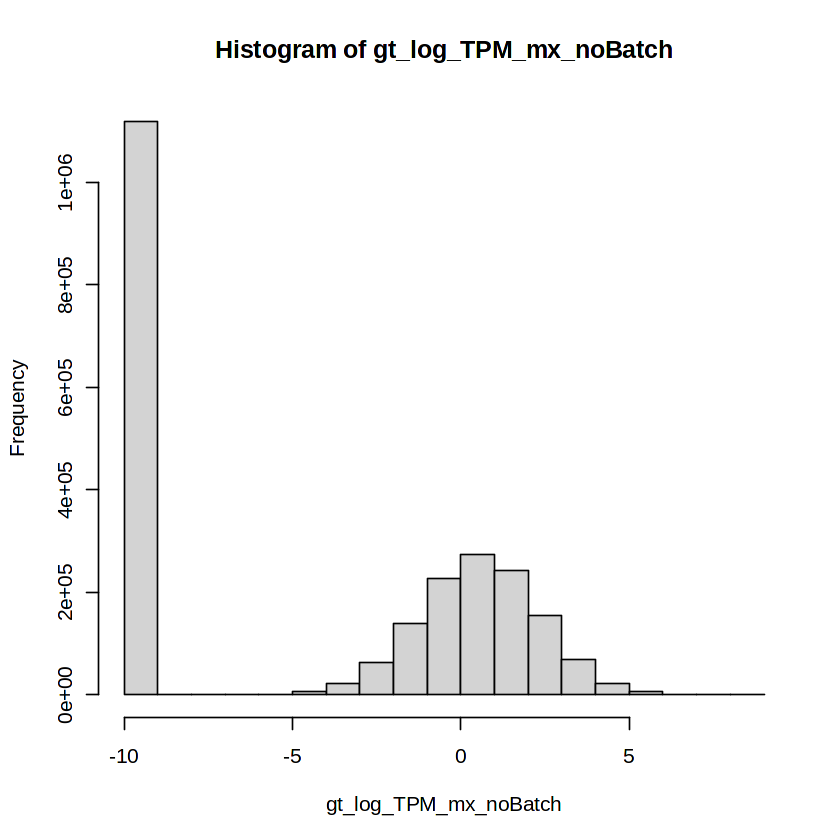

In [9]:
hist(gt_log_TPM_mx_noBatch)

In [10]:
head(t(design_mx)[1:2,])

,1,2,3,4,5,6,7,8,9,10
(Intercept),1,1,1,1,1,1,1,1,1,1
cell_lineSRSF9.KD,0,0,0,0,0,1,1,1,1,1


### Aggregate counts

In [11]:
tpm<-exp(gt_log_TPM_mx_noBatch)
tpm[nonZero_TPMs==0,] <- 0
tpm <- scale(tpm, center = F, scale=colSums(tpm)/1000000)
rownames(tpm)<-iso_res_rsem$transcript_id
colnames(tpm)<-simulation_design$Sample

In [12]:
alt_isos<-alt_isos[alt_isos$ensembl_transcript_id%in%rownames(tpm),]
const_isos<-const_isos[const_isos$ensembl_transcript_id%in%rownames(tpm),]

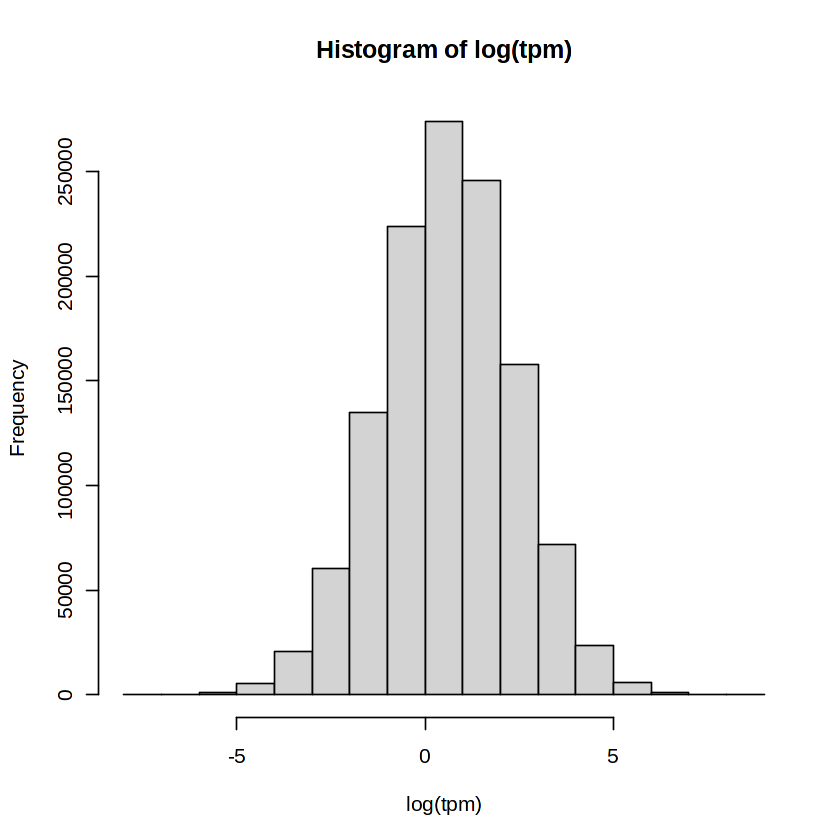

In [13]:
hist(log(tpm))

In [14]:
# Get event counts 
txi<-list("abundance"=tpm,
          "counts"=countsMat,
         "length"=lengthMat)
trex<-create_trex_object(txi,alt_isos,const_isos)

Converting to event counts...

Joining, by = "ensembl_transcript_id"
Joining, by = "ensembl_transcript_id"
Correcting event counts...



In [15]:
colSums(trex$counts)

A_K562_control A_K562_SRSF9.KD  C_K562_control C_K562_SRSF9.KD 
       13177402        19085949        13534668        19823932

#### Calculate PSI, dPSI and dLogPSI

In [16]:
pseudocount<-1e-6
events <- trex$abundance %>% as.data.frame() %>% tibble::rownames_to_column("event_id") %>%
          dplyr::mutate(PSI_K562_control=A_K562_control/(A_K562_control+C_K562_control),
                        PSI_K562_SRSF9.KD=A_K562_SRSF9.KD/(A_K562_SRSF9.KD+C_K562_SRSF9.KD)) %>%
          dplyr::mutate(dPSI_SRSF9.KD_vs_control=PSI_K562_SRSF9.KD-PSI_K562_control,
                        logit_dPSI_SRSF9.KD_vs_control=log(PSI_K562_SRSF9.KD/(1-PSI_K562_SRSF9.KD)) - log(PSI_K562_control/(1-PSI_K562_control)),
                        log_dPSI_SRSF9.KD_vs_control=log(PSI_K562_SRSF9.KD/PSI_K562_control)) %>% 
          tibble::column_to_rownames("event_id")
print(paste("Total events with alternative and constitutive transcripts:",nrow(events)))

[1] "Total events with alternative and constitutive transcripts: 50564"


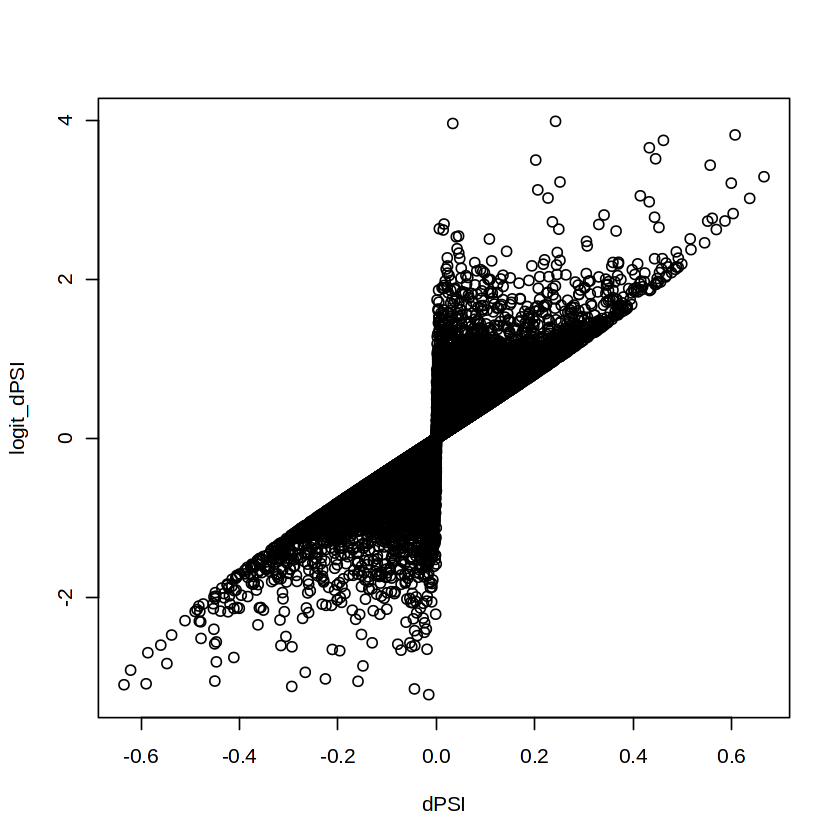

In [17]:
plot(events$dPSI_SRSF9.KD_vs_control,events$logit_dPSI_SRSF9.KD_vs_control,xlab="dPSI",ylab="logit_dPSI")

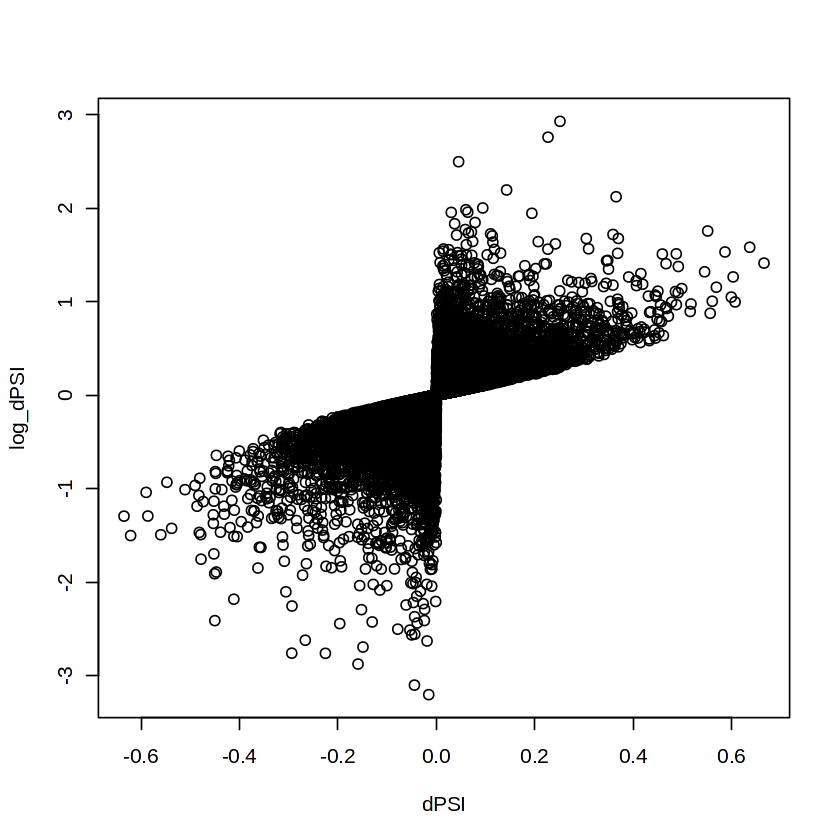

In [18]:
plot(events$dPSI_SRSF9.KD_vs_control,events$log_dPSI_SRSF9.KD_vs_contro,xlab="dPSI",ylab="log_dPSI")

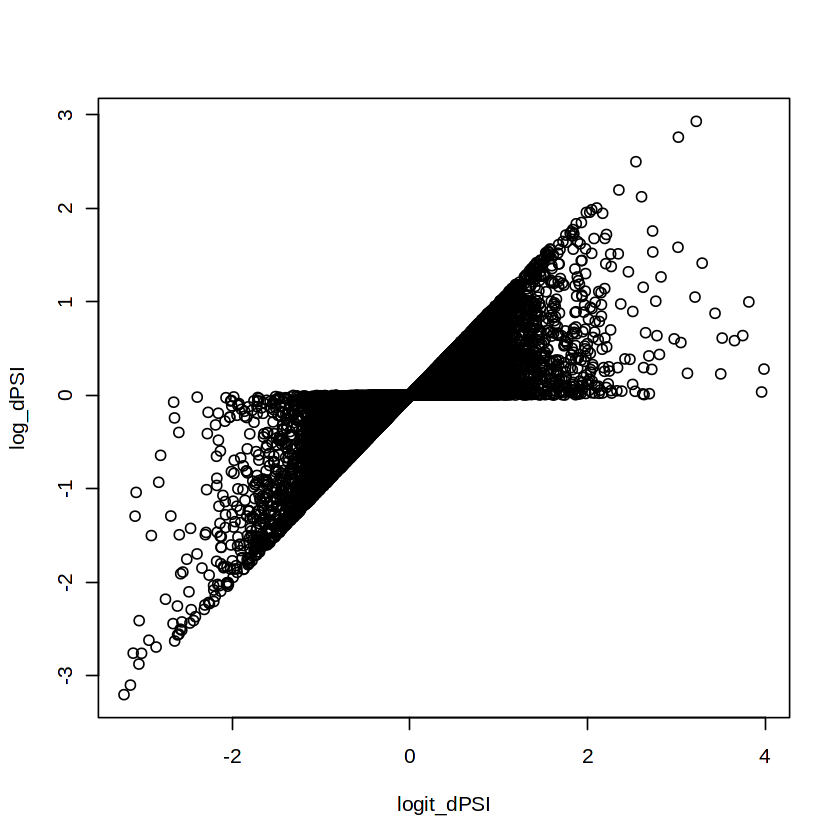

In [19]:
plot(events$logit_dPSI_SRSF9.KD_vs_control,events$log_dPSI_SRSF9.KD_vs_contro,xlab="logit_dPSI",ylab="log_dPSI")

#### Write reference

In [20]:
write.table(events,file = "../data/ground_truth_lenCorrected_PSI.tsv",row.names = T)